In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES']='2'

In [2]:
from keras.layers import Conv2D,Input
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from keras.layers import concatenate

Using TensorFlow backend.


In [3]:
from middleDataGenerator import getTrainDataAndMask
from middleDataGenerator import batch_generator
import math
from skimage.external import tifffile as tiff
import numpy as np
import matplotlib.pyplot as plt

In [4]:
class branch1Network():
    def __init__(self,input_shape):
        self.input_shape=input_shape
        self.input = Input(self.input_shape)
    def network(self):
        x = Conv2D(24,kernel_size=1,padding='same',activation='relu')(self.input)
        return x

class branch2Network():
    def __init__(self,input_shape):
        self.input_shape=input_shape
        self.input = Input(self.input_shape)
    def network(self):
        x = Conv2D(24,kernel_size=1,padding='same',activation='relu')(self.input)
        return x

class branch3Network():
    def __init__(self,input_shape):
        self.input_shape=input_shape
        self.input = Input(self.input_shape)
    def network(self):
        x = Conv2D(24,kernel_size=1,padding='same',activation='relu')(self.input)
        return x

def defModel(input_shape,num_class):
    x1 = branch1Network(input_shape)
    x2 = branch2Network(input_shape)
    x3 = branch3Network(input_shape)
    x = concatenate([x1.network(),x2.network(),x3.network()],axis=3)
    
    ####################
    x = Conv2D(num_class,kernel_size=1,padding='same',activation='softmax')(x)
    rg = Model([x1.input,x2.input,x3.input],x)
    rg.compile(loss='categorical_crossentropy',optimizer="adam",metrics=['accuracy'])
    return rg

In [5]:
class Callbacks:
    checkpoint = ModelCheckpoint("weight/test.h5",save_best_only=True,save_weights_only=True)
class TrainData:
    trainX,trainY = getTrainDataAndMask("data/5056222_2016-07-02_RE1_3A_739012_part.tif","data/kklabel.png")
class Model:
    net = defModel(input_shape=(256,256,5),num_class=12)

In [6]:
Model.net.fit_generator(batch_generator(TrainData.trainX,TrainData.trainY,2),steps_per_epoch=200,
                           validation_data = batch_generator(TrainData.trainX,TrainData.trainY,2),validation_steps=2,
                           callbacks=[Callbacks.checkpoint],epochs=20,verbose=1)

Epoch 1/20
200/200 [==============================] - 8s 39ms/step - loss: 3.3383 - acc: 0.3952 - val_loss: 1.8390 - val_acc: 0.3574
Epoch 2/20
200/200 [==============================] - 6s 29ms/step - loss: 2.0941 - acc: 0.4457 - val_loss: 6.5551 - val_acc: 0.3600
Epoch 3/20
200/200 [==============================] - 6s 29ms/step - loss: 2.2930 - acc: 0.4309 - val_loss: 1.2223 - val_acc: 0.5289
Epoch 4/20
200/200 [==============================] - 6s 30ms/step - loss: 2.2488 - acc: 0.4447 - val_loss: 1.6415 - val_acc: 0.4552
Epoch 5/20
200/200 [==============================] - 6s 29ms/step - loss: 2.0632 - acc: 0.4783 - val_loss: 2.4262 - val_acc: 0.4052
Epoch 6/20
200/200 [==============================] - 6s 30ms/step - loss: 2.0134 - acc: 0.4589 - val_loss: 1.5162 - val_acc: 0.4982
Epoch 7/20
200/200 [==============================] - 6s 28ms/step - loss: 2.0886 - acc: 0.4687 - val_loss: 1.4474 - val_acc: 0.5091
Epoch 8/20
200/200 [==============================] - 6s 30ms/step - 

In [7]:
Model.net.load_weights("weight/test.h5")

In [8]:
def predictData(modelt,data_path):
    x_img = tiff.imread(data_path)/255
    ocr = np.zeros((math.ceil(x_img.shape[0]/256)*256,math.ceil(x_img.shape[1]/256)*256,5),'float16')
    ocr[0:x_img.shape[0],0:x_img.shape[1],:]=x_img
    tmp = np.zeros((math.ceil(x_img.shape[0]/256)*256,math.ceil(x_img.shape[1]/256)*256))
    for i in range(int(ocr.shape[0]/128)-1):
        for j in range(int(ocr.shape[1]/128)-1):
            pred = modelt.predict([np.expand_dims(ocr[128*i:128*(i+1)+128,128*j:128*(j+1)+128,:],0),
                                   np.expand_dims(ocr[128*i:128*(i+1)+128,128*j:128*(j+1)+128,:],0),
                                   np.expand_dims(ocr[128*i:128*(i+1)+128,128*j:128*(j+1)+128,:],0)])
            pred = np.squeeze(pred)
            tmp[128*i:128*(i+1)+128,128*j:128*(j+1)+128] = pred.argmax(axis=2)
    rg =np.zeros((x_img.shape[0],x_img.shape[1]))
    rg = tmp[0:x_img.shape[0],0:x_img.shape[1]]
    tmpt = np.zeros((x_img.shape[0],x_img.shape[1],5))
    for t in range(5):
        tmpt[:,:,t]=rg
    tmpt[x_img==0] = 0
    return tmpt[:,:,0]

In [9]:
result = predictData(Model.net,"data/5056222_2016-07-02_RE1_3A_739012_part.tif")

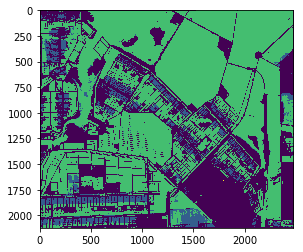

In [10]:
plt.imshow(result)